In [1]:
## imports
import numpy as np
import pandas as pd
from matplotlib import *
import matplotlib.pyplot as plt
import nltk

In [2]:
train=pd.read_csv("train_2kmZucJ.csv")

In [3]:
test=pd.read_csv("test_oJQbWVk.csv")

In [4]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [5]:
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [6]:
class_0=train[train['label']==0]
class_1=train[train['label']==1]

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

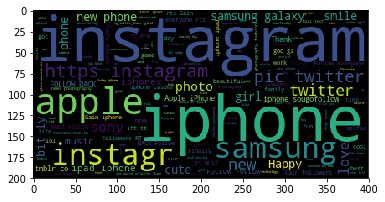

In [8]:
wc=WordCloud().generate(' '.join(class_0['tweet']))
plt.imshow(wc)

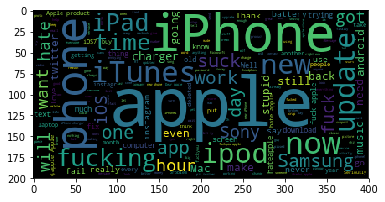

In [9]:
wc1=WordCloud().generate(' '.join(class_1['tweet']))
plt.imshow(wc1)

In [10]:
nltk.corpus.stopwords.words('english')
stop_words=nltk.corpus.stopwords.words('english')
junk_words=["amp",'rt','https','will']
len(stop_words)
stop_words.extend(junk_words)
len(stop_words)

183

In [11]:
## cleaning the data
docs=train['tweet'].str.lower()
docs.head()
docs=docs.str.replace('[^a-z #@]','') # retain all alphabets with #@
docs.head()

0    #fingerprint #pregnancy test httpsgooglhmfqv #...
1    finally a transparant silicon case  thanks to ...
2    we love this would you go #talk #makememories ...
3    im wired i know im george i was made that way ...
4    what amazing service apple wont even talk to m...
Name: tweet, dtype: object

In [12]:
#test
## cleaning the data
docs_t=test['tweet'].str.lower()
docs_t.head()
docs_t=docs_t.str.replace('[^a-z #@]','') # retain all alphabets with #@
docs_t.head()

0    i hate the new #iphone upgrade wont let me dow...
1    currently shitting my fucking pants #apple #im...
2    id like to puts some cdroms on my ipad is that...
3    my ipod is officially dead i lost all my pictu...
4    been fighting itunes all night i only want the...
Name: tweet, dtype: object

In [13]:
stemmer=nltk.PorterStemmer()
def clean_text(row_text):
    #print(type(row_text))
    row_words=row_text.split(' ')
    #print(row_words)
    row_words= [stemmer.stem(word) for word in row_words if word not in stop_words]
    #print(row_words)
    #print('----')
    return ' '.join(row_words)

docs_clean=docs.apply(lambda v: clean_text(v))

In [14]:
stemmer=nltk.PorterStemmer()
def clean_text(row_text):
    #print(type(row_text))
    row_words=row_text.split(' ')
    #print(row_words)
    row_words= [stemmer.stem(word) for word in row_words if word not in stop_words]
    #print(row_words)
    #print('----')
    return ' '.join(row_words)

docs_clean_t=docs_t.apply(lambda v: clean_text(v))

In [16]:
train["clean_one"]=docs_clean
test["clean_one"]=docs_clean_t

In [17]:
df=train[["clean_one","label"]]

In [18]:
df.head()

,clean_one,label
0,#fingerprint #pregnanc test httpsgooglhmfqv #a...,0
1,final transpar silicon case thank uncl #yay ...,0
2,love would go #talk #makememori #unplug #relax...,0
3,im wire know im georg made way #iphon #cute #...,0
4,amaz servic appl wont even talk question unles...,1


In [19]:
# or else go with df
from sklearn.model_selection import train_test_split

train1,validate= train_test_split(docs_clean,test_size=0.3, random_state=100)
train_y=train.loc[train1.index]["label"]
validate_y=train.loc[validate.index]["label"]

In [20]:
train1.shape, validate.shape,train_y.shape,validate_y.shape

((5544,), (2376,), (5544,), (2376,))

In [24]:
df1=test['clean_one']

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
cv=CountVectorizer()
cv.fit(train1)
test_x_sparse=cv.transform(df1)
train_x_sparse=cv.transform(train1)
validate_x_sparse=cv.transform(validate)

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
dt_model=DecisionTreeClassifier(max_depth=20,random_state=100)
dt_model.fit(train_x_sparse,train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, make_scorer
from tqdm import tqdm
SEED = 1
model_full_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=SEED, n_jobs=-1)
model_full_rf.fit(train_x_sparse,train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [29]:
model_full_rf.score(validate_x_sparse,validate_y)
#model_full_rf.score(train_x_sparse,train_y)

0.8859427609427609

In [34]:
pred_test_class=dt_model.predict(test_x_sparse)

In [35]:
submission=pd.DataFrame({'id':test['id'],'label':pred_test_class})
submission.to_csv("sub.csv",index=True)
submission.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


In [36]:
#lets train with whole data

In [37]:
X_train=train["clean_one"]

In [38]:
y_train=train["label"]

In [39]:
cv=CountVectorizer()
cv.fit(X_train)
test_x_s=cv.transform(df1)
train_x_s=cv.transform(X_train)

In [40]:
model_full_rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=SEED, n_jobs=-1)
model_full_rf.fit(train_x_s,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [41]:
pred_test_class1=model_full_rf.predict(test_x_s)

In [42]:
submission=pd.DataFrame({'id':test['id'],'label':pred_test_class})
submission.to_csv("submissionnn.csv",index=True)
submission.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


In [43]:
model_full_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=SEED, n_jobs=-1)
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(base_estimator=model_full_rf, n_estimators=50, random_state=1)
#abcl = AdaBoostClassifier(n_estimators=50)
abcl1 = abcl.fit(train_x_s,y_train)